# Part 1
##Loading the Data

###Imports

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import zscore
import requests

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
font_url = "https://github.com/dmembreno/first_repo/raw/refs/heads/main/Lora-VariableFont_wght.ttf"
font_path = "/tmp/Lora-VariableFont_wght.ttf"
response = requests.get(font_url)
with open(font_path, "wb") as f:
    f.write(response.content)
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "Lora"

###Overview
This dataset was found on Kaggle and was directly sourced from the Steam Official Store through web scraping. The original post contains three CSV files with detailed information about video games and their reviews. For this analysis, we will focus specifically on the "games" CSV file and not the other two, which contain data on users and reviews. The "games" file has over 50,750 observations and 13 columns. In our analysis, we will focus on the "rating" category, which serves as our target variable.
###Rating

Analyzing ratings data is crucial for understanding consumer preferences and predicting trends in the gaming industry. By identifying how different factors can influence user ratings, developers can create more engaging games that meet player expectations. This data could also potentially help businesses target marketing efforts effectively, focusing on games with higher success potential. Ultimately, my hope is that this kind of work can influence better and informed decision making

###Loading the Data

In [ ]:
# Loading dataset from GitHub
site = 'https://github.com'
repo = '/dmembreno/first_repo/raw/refs/heads/main'
file = '/games.csv'
url = site + repo + file
df = pd.read_csv(url)
df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


The first thing I noticed was the app_id variable. Since we weren’t focusing on specific games, it made sense to drop this column, along with the title column. I also realized that the boolean columns (win, mac, Linux, and steam_deck) could be converted to numerical values, replacing the True/False entries with 1s and 0s. Given that our target variable is categorical, I knew the models we would be using would be classification-based.

###Data Cleaning

In [ ]:
df = df.drop_duplicates()
df = df.dropna()

In [ ]:
df['win'] = df['win'].astype(int)
df['mac'] = df['mac'].astype(int)
df['linux'] = df['linux'].astype(int)
df['steam_deck'] = df['steam_deck'].astype(int)
df = df.drop(columns=['app_id', 'title'])
df.head()

,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,2008-11-21,1,0,0,Very Positive,84,2199,9.99,9.99,0.0,1
1,2011-08-03,1,0,0,Positive,85,21,2.99,2.99,0.0,1
2,2013-04-24,1,1,1,Very Positive,92,3722,14.99,14.99,0.0,1
3,2014-11-18,1,0,0,Mixed,61,873,14.99,14.99,0.0,1
4,2014-10-27,1,1,0,Very Positive,88,8784,11.99,11.99,0.0,1


After dropping the duplicate and NA rows, I converted the boolean columns to numerical and dropped 'app_id' and 'title'

In [ ]:
len(df)

50872

In [ ]:
# Remove outliers using Z-score (threshold of 3)
numerical_columns = ['win', 'mac', 'linux', 'steam_deck','price_final','price_original','discount']
df[numerical_columns] = df[numerical_columns].apply(lambda x: np.where(np.abs(zscore(x)) > 3, np.nan, x))
df = df.dropna()
df.head()


,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,2008-11-21,1.0,0.0,0.0,Very Positive,84,2199,9.99,9.99,0.0,1.0
1,2011-08-03,1.0,0.0,0.0,Positive,85,21,2.99,2.99,0.0,1.0
2,2013-04-24,1.0,1.0,1.0,Very Positive,92,3722,14.99,14.99,0.0,1.0
3,2014-11-18,1.0,0.0,0.0,Mixed,61,873,14.99,14.99,0.0,1.0
4,2014-10-27,1.0,1.0,0.0,Very Positive,88,8784,11.99,11.99,0.0,1.0


In [ ]:
len(df)

46918

To avoid retaining outliers in my data, I came across a method called the Z-Score. The Z-Score is a statistical measure used to identify significant outliers in numerical data. The method works by subtracting the mean of a column from each numerical value and then dividing the result by the standard deviation of that column. If the Z-Score is greater than 3 (or less than -3), the row is considered an outlier and is dropped. This approach should help reduce confusion when we begin modeling and creating plots. As we can see here, after removing outliers we were left with 46918 out of 50872 original rows in our data frame.

In [ ]:

df['date_release'] = pd.to_datetime(df['date_release'], errors='coerce')

df.loc[:, 'year'] = df['date_release'].dt.year
df.loc[:, 'month'] = df['date_release'].dt.month
df.loc[:, 'day'] = df['date_release'].dt.day


In the 'release_date' column, there were three potential individual numerical components: 'year', 'month', and 'day'. After confirming that the 'release_date' was correctly formatted as a DateTime variable, I extracted these components and separated them into three new numerical columns.

In [ ]:
rating_mapping = {
    'Very Negative': 'Negative',
    'Mostly Negative': 'Negative',
    'Negative': 'Negative',
    'Mixed': 'Mixed',
    'Mostly Positive': 'Positive',
    'Positive': 'Positive',
    'Very Positive': 'Positive',
    'Overwhelmingly Negative': 'Negative',
    'Overwhelmingly Positive': 'Positive'
}
df['rating_bin'] = df['rating'].map(rating_mapping)

# Convert rating_bin to categorical values (numeric)
df['rating_bin'] = df['rating_bin'].astype('category').cat.codes

# Drop the original 'date_release' and 'rating' columns
df = df.drop(columns=['date_release', 'rating'])

df.head()


,win,mac,linux,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,year,month,day,rating_bin
0,1.0,0.0,0.0,84,2199,9.99,9.99,0.0,1.0,2008,11,21,2
1,1.0,0.0,0.0,85,21,2.99,2.99,0.0,1.0,2011,8,3,2
2,1.0,1.0,1.0,92,3722,14.99,14.99,0.0,1.0,2013,4,24,2
3,1.0,0.0,0.0,61,873,14.99,14.99,0.0,1.0,2014,11,18,0
4,1.0,1.0,0.0,88,8784,11.99,11.99,0.0,1.0,2014,10,27,2


In [ ]:
df1 = df.drop(columns=['positive_ratio'])

The last few code blocks completed the data-cleaning process. I created a new column called 'rating_bin', which is a simplified version of the original 'rating' target variable. We mapped the old 'rating' values into three new categories: positive, negative, and mixed, to avoid confusion and keep things simple.

I also dropped the original 'date_released' column, as we had already split it into separate components, along with the original 'rating' column. To ensure everything was processed correctly, I reviewed the head of the data frame.

Lastly, I removed the 'positive_ratio' column because it was highly similar to the 'rating_bin' variable. When initially configuring the models, I ran into issues because I hadn’t dropped this column, which caused the model's accuracy to appear unrealistically high (99% and above). This was clearly due to the redundancy caused by the 'positive_ratio' column.

#Data Dictionary

### Data Dictionary

| **Variable Name**      | **Description**                                                                                              |
|------------------------|--------------------------------------------------------------------------------------------------------------|
| **win**                | Indicates if the product supports Windows. A Numerical value where 1 (True) means it supports Windows and 0 (False) means it does not. |
| **mac**                | Indicates if the product supports MacOS. A Numerical value where 1 (True) means it supports MacOS and 0 (False) means it does not. |
| **linux**              | Indicates if the product supports Linux. A Numerical value where 1 (True) means it supports Linux and 0 (False) means it does not. |
| **user_reviews**       | The number of user reviews available for the product on Steam. Represented as an integer.                     |
| **price_final**        | The price of the product after any discounts have been applied, represented in US dollars (decimal format).    |
| **price_original**     | The original price of the product before any discounts were applied, represented in US dollars (decimal format). |
| **discount**           | The discount applied to the product, represented as a decimal.                 |
| **steam_deck**         | Indicates if the product supports Steam Deck. A Numerical value where 1 (True) means it supports Steam Deck and 0 (False) means it does not. |
| **year**               | The year the product was released, represented as an integer (e.g., 2008, 2015).                             |
| **month**              | The month the product was released, represented as an integer (1 to 12).                                      |
| **day**                | The day the product was released, represented as an integer (1 to 31).                                        |
| **rating_bin**         | The binned rating category of the product, where 0 represents a negative rating, 1 represents a mixed rating and 2 represents a positive rating. |

#Useful Plots
##Univariate and Multivariate

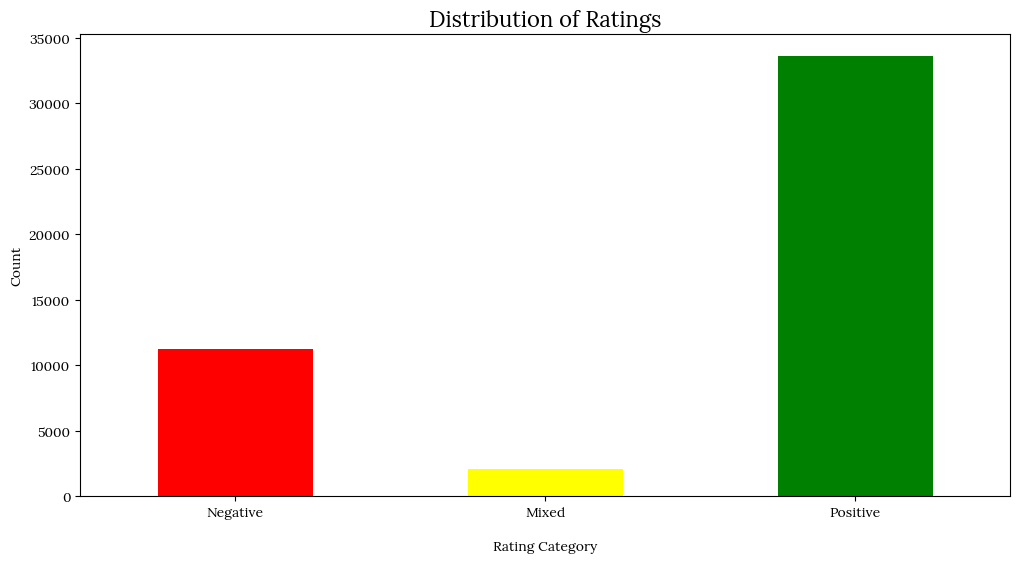

In [ ]:
plt.figure(figsize=(12, 6))
df1['rating_bin'].value_counts().sort_index().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Distribution of Ratings',fontsize = 16)
plt.xlabel('Rating Category',labelpad= 15)
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Mixed', 'Positive'], rotation=0)
plt.show()

In the 'rating_bin' column, the distribution of categories is not even. The positive counts are much higher than the negative ones, and the mixed ratings are almost nonexistent. This suggests that, generally, user reviews are more favorable than not toward the games observed in this dataset.

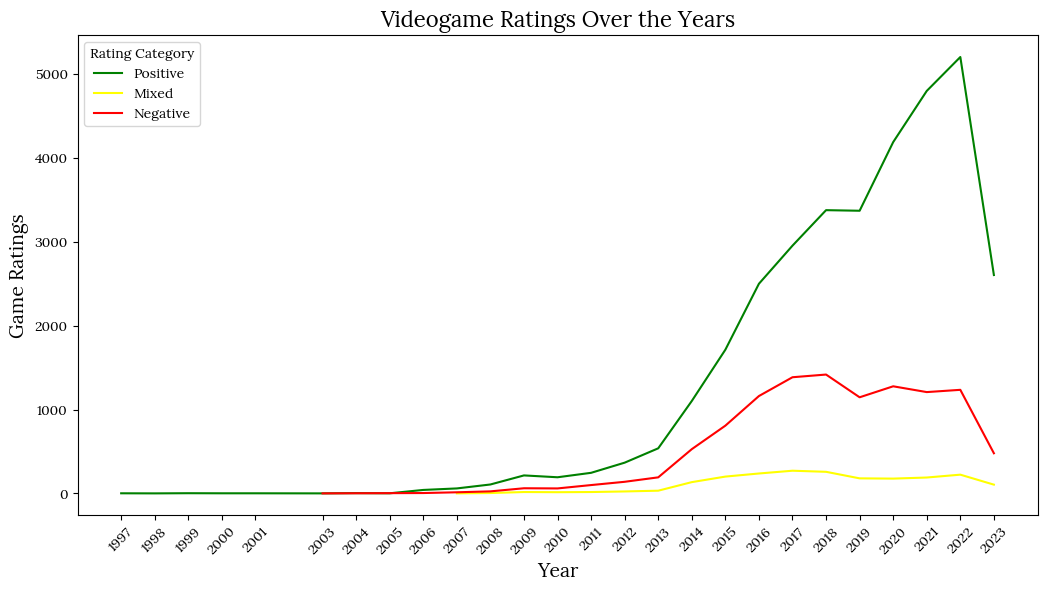

In [ ]:
rating_counts = df1.groupby(['year', 'rating_bin']).size().reset_index(name='count')
rating_counts['year'] = rating_counts['year'].astype(int)

plt.figure(figsize=(12, 6))
sns.lineplot(data=rating_counts, x='year', y='count', hue='rating_bin', palette=['green', 'yellow', 'red'], hue_order=[2, 1, 0], marker='o', markersize=0, linestyle='-')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.title('Videogame Ratings Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Game Ratings', fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Positive', 'Mixed', 'Negative'], title='Rating Category', loc='upper left')

plt.xticks(ticks=rating_counts['year'].unique(), rotation=45)
plt.show()

From 1997 to 2023, the reviews have generally remained positive. While the proportion of negative and mixed reviews has gradually increased alongside the positive reviews, they are still far fewer in number. This trend likely reflects the overall growth in the number of video games on Steam, especially after late 2008. As the number of games increased, so did the volume of reviews and the diversity of opinions. This aligns with my expectations.

In [ ]:
#values in rating bin that ar mixed
print(df1['rating_bin'].value_counts())

rating_bin
2    33585
0    11242
1     2091
Name: count, dtype: int64


<ipython-input-32-d24afc04bb93>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='rating_bin', y='price_original', data=df1, palette=['red', 'yellow', 'green'])


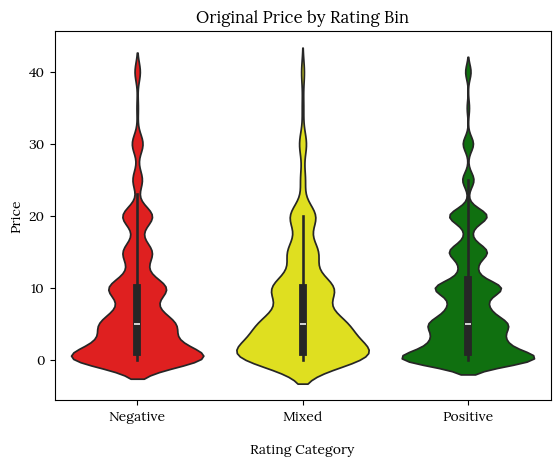

In [ ]:
sns.violinplot(x='rating_bin', y='price_original', data=df1, palette=['red', 'yellow', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Mixed', 'Positive'])
plt.title('Original Price by Rating Bin')
plt.xlabel('Rating Category',labelpad=15)
plt.ylabel('Price')
plt.show()

I examined the relationship between the 'rating_bin' and 'price_original' variables. I found that the distributions of all three subcategories in 'rating_bin' are similar in shape. Each distribution is larger near the lower end and gradually tapers off, with a noticeable decrease after the 10. Additionally, all distributions contain extreme values that extend beyond the 95th percentile confidence interval. This suggests that, while there are some higher-priced games above the 25th percentile, there is no clear relationship between the original price and the rating category.

<ipython-input-33-c848360f50f8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='rating_bin', y='price_final', data=df1, palette=['red', 'yellow', 'green'])


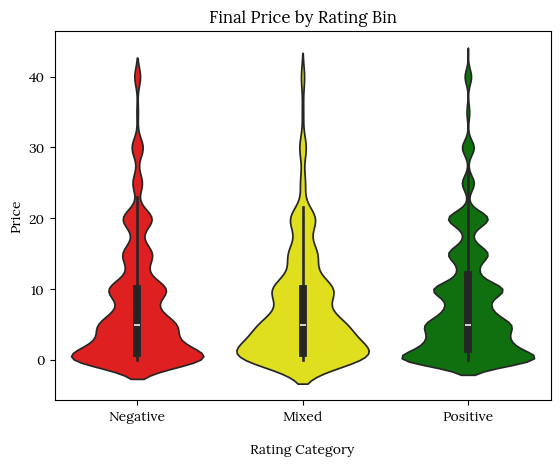

In [ ]:
sns.violinplot(x='rating_bin', y='price_final', data=df1, palette=['red', 'yellow', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Mixed', 'Positive'])
plt.title('Final Price by Rating Bin')
plt.xlabel('Rating Category', labelpad=15)
plt.ylabel('Price')
plt.show()

Like the previous violin plot, all the categories here exhibit a similar profile. This suggests that while 'price_original' and 'price_final' may influence the outcome of 'rating_bin', they are not as majorly influential compared to other features.

<ipython-input-34-f53f0ccb8b6d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_bin', y='price_original', data=df1, palette=['red', 'yellow', 'green'])


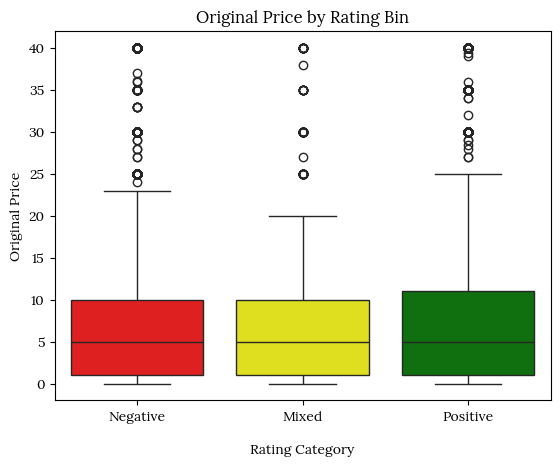

<ipython-input-34-f53f0ccb8b6d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating_bin', y='price_final', data=df1, palette=['red', 'yellow', 'green'])


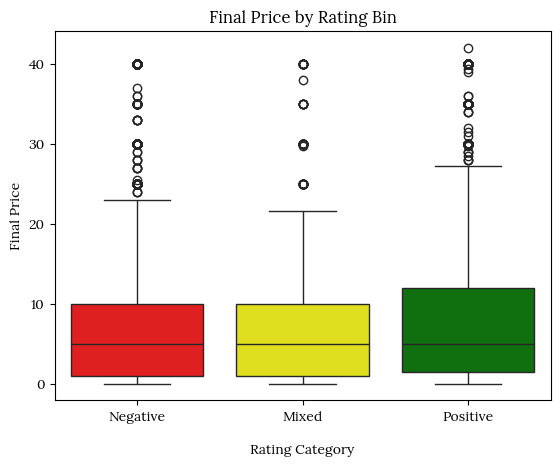

In [ ]:
sns.boxplot(x='rating_bin', y='price_original', data=df1, palette=['red', 'yellow', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Mixed', 'Positive'])
plt.title('Original Price by Rating Bin')
plt.xlabel('Rating Category', labelpad=15)
plt.ylabel('Original Price')
plt.show()

sns.boxplot(x='rating_bin', y='price_final', data=df1, palette=['red', 'yellow', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Mixed', 'Positive'])
plt.title('Final Price by Rating Bin')
plt.xlabel('Rating Category', labelpad=15)
plt.ylabel('Final Price')
plt.show()

These boxplots are similar to the violin plots, but here we can more directly observe the outliers. The "Mixed" category has far fewer outliers, while "Negative" and "Positive" have significantly more. This may suggest that video games with more extreme positive or negative ratings tend to provoke stronger reactions from consumers, leading them to leave reviews. In contrast, games with more evenly distributed prices might not elicit such definitive responses.

In [ ]:
#correlation with rating_bin
corr_matrix = df1.corr()
corr_matrix['rating_bin'].sort_values(ascending=False)

,rating_bin
rating_bin,1.000000
year,0.097689
mac,0.066475
linux,0.062319
discount,0.031988
price_final,0.019995
user_reviews,0.017451
price_original,0.009616
day,0.004181
month,-0.002376



This correlation matrix provides deeper insights into the relationships between our features and the response variable, 'rating_bin'. The top five variables with the highest correlation to 'rating_bin' are 'year' (9.8%), 'mac' (6.7%), 'linux' (6.2%), 'discount' (3.2%), and 'price_final' (2%). These results suggest that certain factors, such as the year of release and platform support (Mac and Linux), have a modest influence on the rating category. For example, the correlation with 'year' might indicate that more recent games tend to result in higher rating, which we saw on our earlier plot which measured "Videogame Ratings Over the Years".

Interestingly, 'discount' and 'price_final' also show small correlations, implying that pricing strategies may have some influence on the rating, but not a strong one. Games with greater discounts or lower final prices might attract more positive reviews, but this relationship seems weak overall.

The remaining features show minimal or no correlation with 'rating_bin'. Notably, 'win' (Windows support) and 'steam_deck' (Steam Deck support) have no correlation with the rating, suggesting that these factors do not significantly impact how games are rated. This lack of correlation could imply that the gaming experience itself, such as game quality or performance, may be more important than platform compatibility when it comes to rating outcomes.

In summary, while some variables show mild correlations with 'rating_bin', these relationships are not very strong, and other factors not captured in this analysis might be more significant in influencing the ratings.

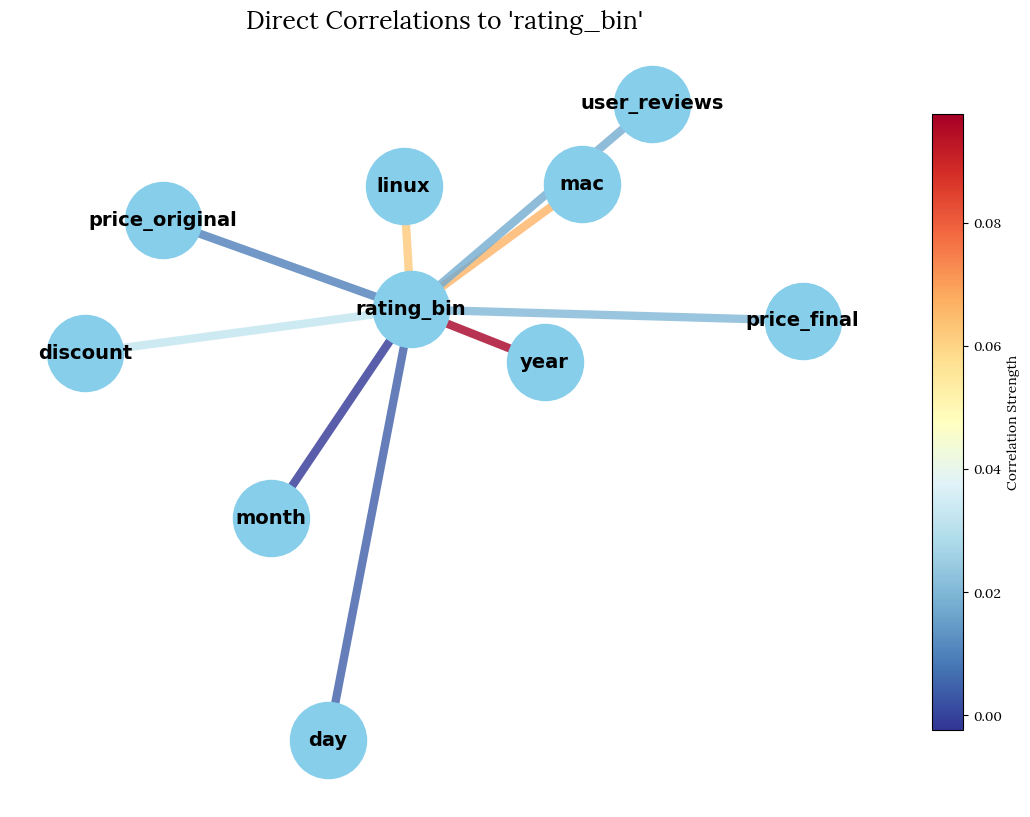

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
G = nx.Graph()
rating_bin_corr = corr_matrix['rating_bin']

#edges to the graph for only those variables directly connected to 'rating_bin'
for column in corr_matrix.columns:
    if column != 'rating_bin' and not np.isnan(rating_bin_corr[column]):
        G.add_edge('rating_bin', column, weight=rating_bin_corr[column])

fig, ax = plt.subplots(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)
pos['mac'] = [0.2, 0.5]
pos['month'] = [-0.3, -0.4]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', ax=ax)
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# Normalized edge weights based on the actual range of correlation values
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))

# Reverse colormap to ensure red is for positive and blue for negative
cmap = plt.colormaps['RdYlBu_r']
edge_colors = [cmap(norm(weight)) for weight in edge_weights]
edge_widths = [6] * len(G.edges())
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8, edge_color=edge_colors, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold', ax=ax)
ax.set_title("Direct Correlations to 'rating_bin'", fontsize=18)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Correlation Strength')
plt.show()


This network graph provides a visual representation of the correlations observed in the previous correlation matrix. The lines connecting the features to the response variable 'rating_bin' are color-coded: the more red the lines are, the stronger the correlation, and the more blue the lines become, the weaker the correlation. From this visualization, we can see that 'linux', 'mac', and 'year' stand out significantly compared to the other features. These features are more strongly connected to the 'rating_bin' variable, indicated by the redder lines, which aligns with the higher correlation percentages seen in the matrix.

In contrast, features like 'win' and 'steam_deck' have very weak or no correlation with 'rating_bin', as shown by their absence. This further demonstrates the lack of influence these variables have on the rating category. Overall

#Part 2
##Modeling Relationships

In [ ]:
X = df1.drop(columns=['rating_bin'])  # Features
y = df1['rating_bin']  # Target

In [ ]:
# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(37534, 11) (9384, 11)


In this analysis, we begin by separating the features and target variable. The feature set is stored in X, which excludes the 'rating_bin' column, while y contains the target variable, 'rating_bin', representing the rating categories.

Next, we split the data into training and test sets using an 80-20 split, where X_train and y_train represent the training data, and X_test and y_test are used for testing.

In [ ]:
# Random Forest with base hyperparameters
rf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores_rf = cross_val_score(rf, X, y, cv=5)
print(f'Random Forest Cross-Validation Scores: {cv_scores_rf}')
print(f'Random Forest Mean Cross-Validation Accuracy: {cv_scores_rf.mean()}')

# Fit the model
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))


Random Forest Cross-Validation Scores: [0.69416027 0.6958653  0.67774936 0.64307791 0.69071725]
Random Forest Mean Cross-Validation Accuracy: 0.68031401950472
Random Forest Accuracy: 0.691069906223359
              precision    recall  f1-score   support

           0       0.35      0.16      0.21      2231
           1       0.22      0.03      0.06       427
           2       0.74      0.91      0.81      6726

    accuracy                           0.69      9384
   macro avg       0.43      0.37      0.36      9384
weighted avg       0.62      0.69      0.64      9384



I applied a Random Forest Classifier with 100 estimators and used 5 fold cross validation to evaluate the models ability to generalize. After training on the training data, the model predicts the test set. We evaluate its performance by calculating accuracy and generating a classification report with precision, recall, and F1-score. This process allows us to assess the model’s ability to predict the 'rating_bin' variable and its overall performance.



While it performs well in predicting category "2" 'Positive' (with a high precision, recall, and F1-score), it struggles with categories "0" 'Negative' and "1" 'Mixed', showing lower precision and recall, especially for category "1". This suggests the model is biased toward predicting the 'Positve' while having difficulty distinguishing between the other categories.


Perhaps this has to do with the weight of the categories within the dataset itself. The majority of the values in 'review_bin' were positive with negative trailing far behind and mixed being almost non-existent.

In [ ]:
# Trying hyperparameters: n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=1
# Cross-validation accuracy: 0.7157442621487815

In [ ]:
# Gradient Boosting with manually set hyperparameters
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

# Perform cross-validation
cv_scores_gb = cross_val_score(gb, X, y, cv=5)
print(f'Gradient Boosting Cross-Validation Scores: {cv_scores_gb}')
print(f'Gradient Boosting Mean Cross-Validation Accuracy: {cv_scores_gb.mean()}')

# Fit the model
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Evaluate Gradient Boosting
print(f'Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb)}')
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Cross-Validation Scores: [0.71259591 0.71057118 0.70822677 0.70382607 0.71490994]
Gradient Boosting Mean Cross-Validation Accuracy: 0.7100259747658129
Gradient Boosting Accuracy: 0.7150468883205456
              precision    recall  f1-score   support

           0       0.34      0.01      0.03      2231
           1       0.00      0.00      0.00       427
           2       0.72      0.99      0.83      6726

    accuracy                           0.72      9384
   macro avg       0.35      0.34      0.29      9384
weighted avg       0.60      0.72      0.60      9384



For the Gradient Boosting model, I manually set up the hyperparameters and evaluated its performance using 5-fold cross-validation. The model showed strong cross-validation performance with a mean accuracy of 71.00%, and achieved a test accuracy of 71.50%. However, while the model performed well in predicting the 'Positive' category (category "2") with a high recall and F1-score, it struggled significantly with predicting the 'Negative' (category "0") and 'Mixed' (category "1") categories. Precision and recall for these categories were very low, especially for category "1," where the model failed to make meaningful predictions. This suggests that despite the model’s high accuracy, it may be biased toward predicting the 'Positive' category, likely due to class imbalance within the dataset.

In [ ]:
# KNN with manually set hyperparameters
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    algorithm='ball_tree',
    leaf_size=30,
    p=1
)

# Perform cross-validation
cv_scores_knn = cross_val_score(knn, X, y, cv=5)
print(f'KNN Cross-Validation Scores: {cv_scores_knn}')
print(f'KNN Mean Cross-Validation Accuracy: {cv_scores_knn.mean()}')

# Fit the model
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluate KNN
print(f'KNN Accuracy: {accuracy_score(y_test, y_pred_knn)}')
print(classification_report(y_test, y_pred_knn))


KNN Cross-Validation Scores: [0.70076726 0.70428389 0.69064365 0.66428648 0.70158798]
KNN Mean Cross-Validation Accuracy: 0.6923138506916837
KNN Accuracy: 0.6998081841432225
              precision    recall  f1-score   support

           0       0.34      0.10      0.16      2231
           1       0.64      0.02      0.04       427
           2       0.73      0.94      0.82      6726

    accuracy                           0.70      9384
   macro avg       0.57      0.35      0.34      9384
weighted avg       0.63      0.70      0.63      9384



Following the previous models, the K-Nearest Neighbors (KNN) model, with manually configured hyperparameters, achieved a mean cross-validation accuracy of 69.23% and a test accuracy of 69.98%. Like the other models, it excelled in predicting the 'Positive' category (category "2") but struggled with the 'Negative' (category "0") and 'Mixed' (category "1") categories, showing low precision and recall for category "1." This further indicates a bias toward predicting the dominant 'Positive' category, likely due to the class imbalance in the dataset.

####The Best Overall Model

Based on the results from the Random Forest, Gradient Boosting, and K-Nearest Neighbors (KNN) models, Gradient Boosting performs the best overall. It achieved the highest test accuracy at 71.5%, surpassing both Random Forest (69.1%) and KNN (69.9%). Despite the challenges in precision and recall for categories "0" and "1", the model shows strong performance in predicting the 'Positive' category (category "2"), with high recall (99%) and a strong F1-score (83%).

However, the other two models, Random Forest and KNN, also perform similarly in predicting the 'Positive' category, but their overall performance lags behind Gradient Boosting due to their struggles with the other categories. Specifically, KNN struggles with very low recall for 'Mixed' reviews (category "1"), and Random Forest exhibits low precision and recall for both 'Negative' and 'Mixed' categories. Therefore, Gradient Boosting is the most balanced and effective model in terms of overall accuracy and its ability to classify 'Positive' reviews, despite the challenges with class imbalance.

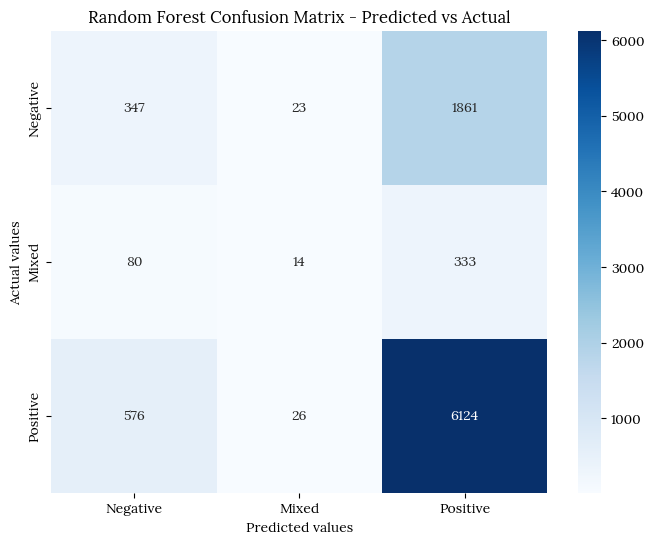

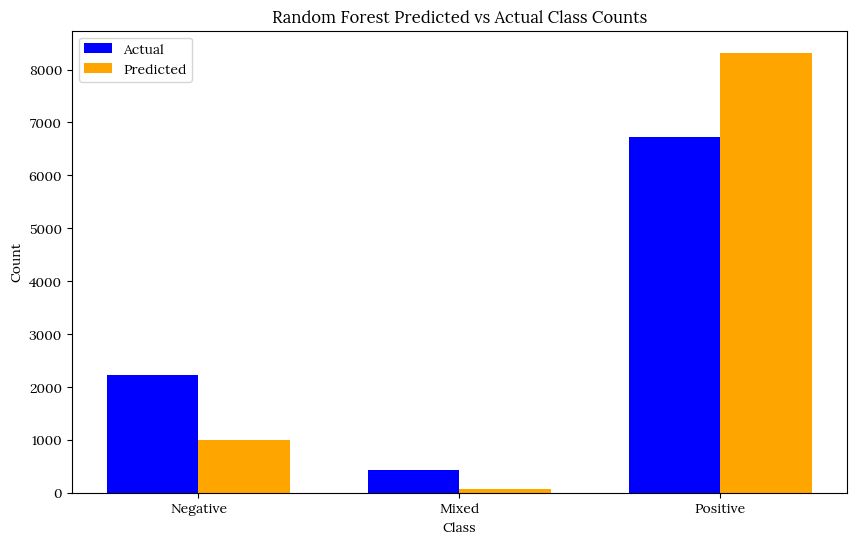

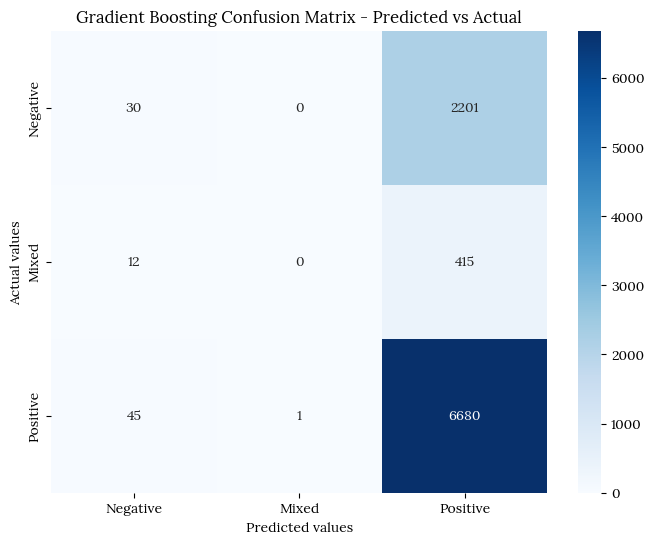

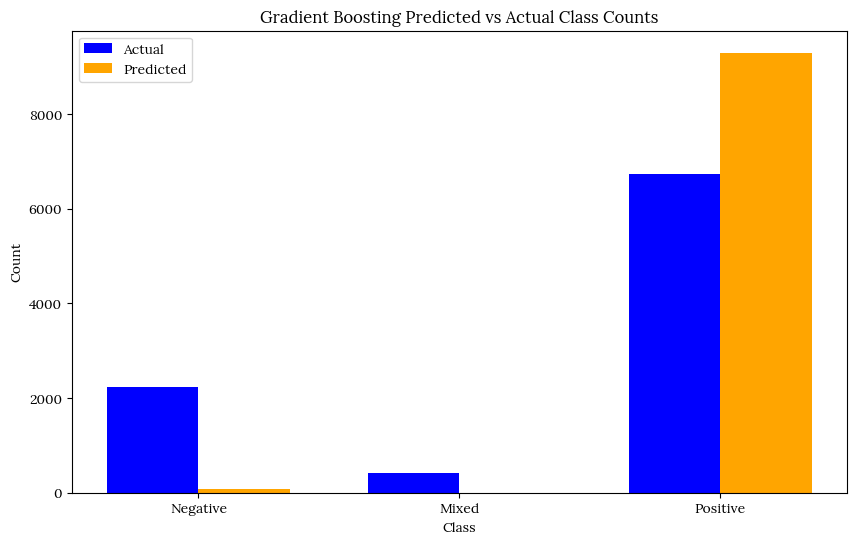

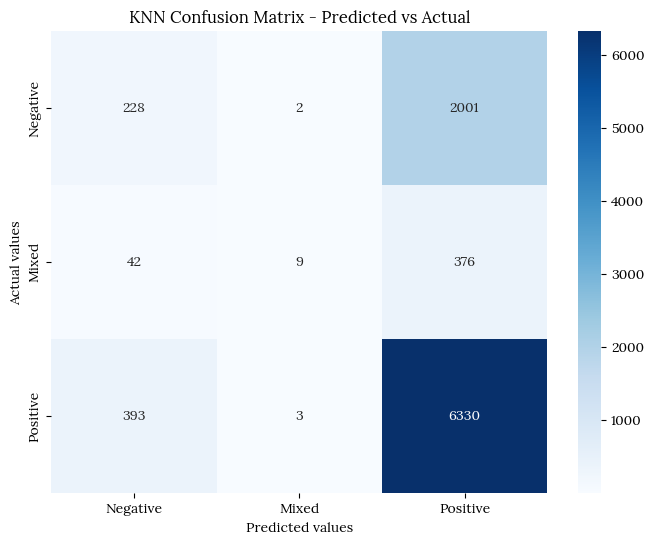

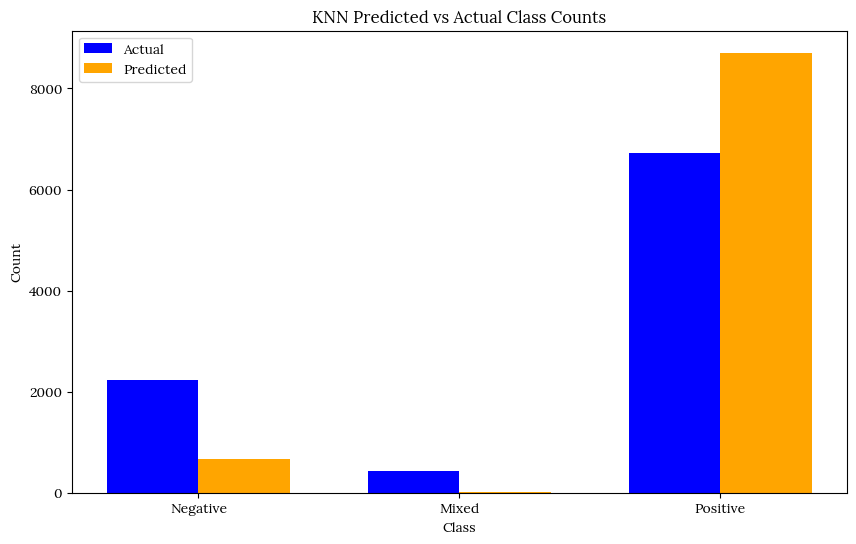

In [ ]:
# Function to plot confusion matrix and predicted vs actual comparison
def plot_results(y_test, y_pred, model_name):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Mixed', 'Positive'],
                yticklabels=['Negative', 'Mixed', 'Positive'])
    plt.title(f'{model_name} Confusion Matrix - Predicted vs Actual')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

    # Bar chart for Predicted vs Actual Class Counts
    df_comparison = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    actual_counts = df_comparison['Actual'].value_counts().sort_index()
    predicted_counts = df_comparison['Predicted'].value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    x = actual_counts.index
    ax.bar(x - width/2, actual_counts.values, width, label='Actual', color='blue')
    ax.bar(x + width/2, predicted_counts.values, width, label='Predicted', color='orange')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{model_name} Predicted vs Actual Class Counts')
    ax.set_xticks(x)
    ax.set_xticklabels(['Negative', 'Mixed', 'Positive'])
    ax.legend()
    plt.show()

plot_results(y_test, y_pred_rf, 'Random Forest')

plot_results(y_test, y_pred_gb, 'Gradient Boosting')

plot_results(y_test, y_pred_knn, 'KNN')


I created these visualizations to more clearly exhibit the insights observed above. The confusion matrices help highlight how each model performs in predicting the 'Negative', 'Mixed', and 'Positive' categories, showcasing where misclassifications occur. The bar charts further emphasize the differences between actual and predicted class distributions, making it easier to visualize the models' performance and their biases, especially when dealing with class imbalances.

In [ ]:
# Accuracy comparison of all models
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(f'Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb)}')
print(f'KNN Accuracy: {accuracy_score(y_test, y_pred_knn)}')


Random Forest Accuracy: 0.691069906223359
Gradient Boosting Accuracy: 0.7150468883205456
KNN Accuracy: 0.6998081841432225


Here is the accuracy of all the models side by side.

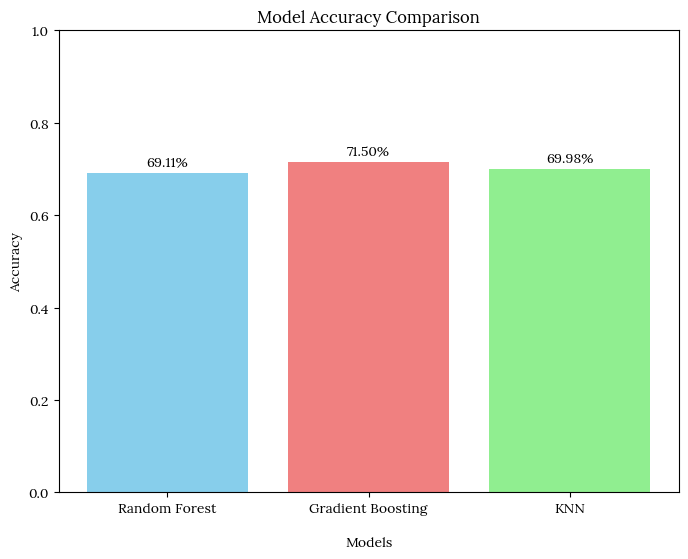

In [ ]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

models = ['Random Forest', 'Gradient Boosting', 'KNN']
accuracies = [rf_accuracy, gb_accuracy, knn_accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])

for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{accuracy:.2%}', ha='center', va='bottom')

plt.xlabel('Models',labelpad=15)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1) # Set y-axis limit to 0-1 for accuracy
plt.show()

These are the model accuracies on a barchart all are quite similar but Gradient Boosting has less classification bias.

In [ ]:
#get the most important feautres for the gradient bosting model
importances = gb.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances.head(10)

,Feature,Importance
3,user_reviews,0.320930
8,year,0.269164
4,price_final,0.118632
10,day,0.085548
5,price_original,0.060483
9,month,0.058689
1,mac,0.038775
2,linux,0.029917
6,discount,0.017861
0,win,0.000000


##Final Conclusions and Recommendations

In [ ]:
import pandas as pd
import plotly.express as px

importance_data = {
    'Feature': ['user_reviews', 'year', 'price_final', 'day', 'price_original',
                'month', 'mac', 'linux', 'discount', 'win'],
    'Importance': [0.320930, 0.269164, 0.118632, 0.085548, 0.060483,
                   0.058689, 0.038775, 0.029917, 0.017861, 0.000000]
}

importance_df = pd.DataFrame(importance_data)
importance_df['Importance (%)'] = importance_df['Importance'] * 100
importance_df = importance_df[importance_df['Importance (%)'] > 0]

fig = px.treemap(importance_df,
                 path=['Feature'],
                 values='Importance (%)',
                 title="Top Features by Importance - Gradient Boosting",
                 color='Importance (%)',
                 color_continuous_scale='Viridis',
                 hover_data={'Feature': False, 'Importance': False, 'Importance (%)': True})

fig.update_traces(textinfo='label+percent entry')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family="Lato, sans-serif"),
    title_font=dict(family="Lato, sans-serif")
)

fig.show()


The treemap illustrating feature importance from the Gradient Boosting model clearly identifies the key factors driving predictions for the 'rating_bin'. The standout features are 'user_reviews' at 32.09%, 'year' at 26.92%, and 'price_final' at 11.86%. It’s undeniable that 'user_reviews' plays a pivotal role; products with higher review counts significantly increase their chances of being classified as 'Positive'. The emphasis on the 'year' of the product reinforces the notion that newer items are typically rated more favorably due to advancements in features or performance.

The 'price_final' feature is equally crucial, indicating that competitive pricing strategies—like discounts—are essential for attracting positive consumer feedback. While other factors such as 'day', 'price_original', and 'month' do exert some influence, their impact pales in comparison.

Furthermore, it’s evident that features like 'mac', 'linux', and 'win' have minimal relevance, suggesting that consumers rarely consider operating system compatibility when rating products.

This analysis provides businesses with actionable insights. Companies must prioritize increasing the quantity of user reviews to enhance ratings, implement effective pricing strategies, and strategically time product releases to meet consumer preferences. By understanding the primary drivers of consumer ratings, businesses can make decisive choices that elevate customer satisfaction and drive significant sales growth.

In [ ]:
!jupyter nbconvert --to html /content/FinalProjectDM.ipynb

[NbConvertApp] Converting notebook /content/FinalProjectDM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 1060653 bytes to /content/FinalProjectDM.html
